#

# LangGraph Detailed Agent
This advances the agent that was done in the langgraph_agent.ipynb notebook and focuses on defining specific roles to the agents/nodes.  Review that one first to see details on the steps as this one will only explain the additional details.

### 1. Load the needed libraries and environment variables
Unlike most notebooks, I am not going to load all of the imports at the top, but load them where they are needed.

In [143]:
from dotenv import load_dotenv
from typing import List, Any, Optional, Annotated, TypedDict
from pydantic import BaseModel, Field
import uuid

import os
import sqlite3
import gradio 

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import BaseTool
from langchain_community.tools import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.agent_toolkits import FileManagementToolkit
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image

In [144]:
load_dotenv(override=True)

True

### 2. Add Tools

In [145]:
def get_tools() -> List[BaseTool]:
    # Define server, wrapper around the Google API, as a tool
    tool_search: Tool = Tool(
        name="search",
        func=GoogleSerperAPIWrapper().run,
        description="Use this tool when you want to get the results of an online web search"
    )

    # Define Wikipedia as a search as a tool
    wikipedia: WikipediaAPIWrapper = WikipediaAPIWrapper()
    wiki_tool: WikipediaQueryRun = WikipediaQueryRun(api_wrapper=wikipedia)

    # Define file management tools
    file_tools: List[BaseTool] = FileManagementToolkit(root_dir="sandbox").get_tools()


    # Concatenate all tools together as a list
    tools: List[BaseTool] = file_tools + [tool_search, wiki_tool]

    return tools

### 3. Setup Memory

In [146]:
db_path = "memory.db"
if os.path.exists(db_path):
    os.remove(db_path)

conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

### 4. Build the Graph
It is now time to put start building the graph.  All graphs include the following steps:
<ol>
<li>Define the State</li>
<li>Start Graph Builder</li>
<li>Create Nodes</li>
<li>Create Edges</li>
<li>Compile the Graph</li>
</ol>

### State with additional details
Will track additional details in the state to help with routing:
<ul>
<li>feedback_on_work: details from the evaluator</li>
<li>success_criteria_met: determines if it should end</li>
<li>reviews: the number of reviews completed as a guardrail from looping too much</li>
</ul>

In [147]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    feedback_on_work: Optional[str]
    success_criteria_met: bool
    reviews: int=0

In [148]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

### Detailed Agent Setup
In this case, we are going to define two agents/nodes with different roles.  The first one will be a "history" expert.  The purpose of this agent is that it can do research on historical events and create a detailed report that will be saved as a markdown file.  This will be given a consistent prompt and the user should only have to supply an event.  The second agent/node is an evaluator.  This evaluator will review the report and ensure provide feedback.  Only after it is statified with the results will the process end.  This will also use two different LLMs with the history export using OpenAI and the reviewer using Gemini.  Each of these agents could also be set up with different tool sets as well, however, in this case, I will make the tools available to both.

#### Define the prompts
I will first define a detailed prompt for both agents.  These may very well need to be fined tuned to get them right.  You can use AI to get a jump start on crafting a good system prompt.

In [149]:
history_expert_system_message = """
You are HistoryExpert, an autonomous research agent specializing in historical events. You have access to Google Search and Wikipedia and must use them when needed to verify facts or gather additional context. Your mission is to take a single historical event as input and generate a deep, comprehensive, meticulously accurate historical report about that event.

OUTPUT REQUIREMENTS:

1. Begin with a concise executive summary. This summary must contain 3–6 bullet points capturing the essential who, what, when, where, why, and outcome of the event. It must be clearly labeled with the header: "## Executive Summary".

2. After the summary, produce a detailed, lengthy, deeply researched historical report. Use section headers where appropriate. The report must include background, causes, chronology, major participants, significance, geopolitical impact, cultural or social consequences, and primary sources when available. Cite sources (Wikipedia or Google) in plain text, not with citation IDs or URLs unless required.

3. At the very end of your response, output a file creation instruction with the exact format:
FILENAME: YYYYMMDDHHmm_<event_name>.md
Where YYYYMMDDHHmm is the current UTC timestamp (or system-provided timestamp), and <event_name> is the event name in snake_case with no spaces. Do not add any text after this line.

4. Tone requirements: Maintain an authoritative, neutral, academic, objective tone. Note when historians disagree. Avoid speculation unless it is explicitly labeled as speculation.

BEHAVIOR RULES:
- Prefer primary historical sources first, then Wikipedia, then Google.
- If the event name is ambiguous, identify any possible interpretations and ask for clarification if absolutely necessary.
- The report must always be highly detailed unless explicitly instructed otherwise.
- Do not produce a summary at the bottom; only at the top.

FINAL OUTPUT FORMAT:
1. "## Executive Summary"
2. Full detailed report
3. Final timestamped file name line, with nothing after it.
4. File MUST be written as output
"""

evaluator_system_message = """
You are HistoryReviewAgent, an autonomous quality-control reviewer responsible for evaluating the output generated by the HistoryExpert agent. You must evaluate the historical report strictly using the structured fields defined in the EvaluatorOutput model:
- feedback (string)
- success_criteria_met (boolean)
- reviews (integer)

Your responsibilities:

1. Evaluate whether the report fully complies with the required structure:
   - Contains an "## Executive Summary" at the top with 3–6 bullet points.
   - Contains a lengthy, detailed historical report covering:
       background, causes, chronology, major participants, significance,
       geopolitical impact, cultural/social consequences, and sources.
   - Uses section headers appropriately.
   - Maintains an objective, academic, historically accurate tone.
   - Avoids speculation unless explicitly labeled as such.
   - File must exist on the drive.
   - Includes the file name at the very end in the exact format:
       FILENAME: YYYYMMDDHHmm_<event_name>.md
   - Contains no text after the file name line.

2. If ALL success criteria are met:
   - Set success_criteria_met = true
   - Set feedback to a short confirmation message such as:
       "Report meets all criteria."
   - Set reviews to any integer value (your code will override/increment it).

3. If ANY criteria are NOT met:
   - Set success_criteria_met = false
   - Set feedback to clear, constructive, actionable correction notes that the HistoryExpert can use.
   - Do NOT reference review numbers or counts.
   - Set reviews to any integer value (your code will override/increment it).

IMPORTANT:
- The agent should NOT attempt to track, reference, or reason about review counts.
- The evaluator MUST NOT rewrite or fix the report — only evaluate it.
- The evaluator MUST NOT include a file name.
- The only output should be the structured fields required by EvaluatorOutput.
"""




In [150]:
# Create the history expert
from langchain_core.messages import AIMessage, ToolMessage
open_ai = ChatOpenAI(model="gpt-4o-mini")
tools_for_history_expert = get_tools()
open_ai_with_tools = open_ai.bind_tools(tools_for_history_expert)

def history_expert(state: State):
    messages = state["messages"]

    # Convert incoming messages to BaseMessage objects
    converted_messages = []
    for msg in messages:
        if isinstance(msg, dict):
            if msg["role"] == "system":
                converted_messages.append(SystemMessage(content=msg["content"]))
            elif msg["role"] == "user":
                converted_messages.append(HumanMessage(content=msg["content"]))
            elif msg["role"] == "assistant":
                converted_messages.append(AIMessage(content=msg.get("content", ""), tool_calls=msg.get("tool_calls")))
            elif msg["role"] == "tool":
                converted_messages.append(ToolMessage(content=msg["content"], tool_call_id=msg.get("tool_call_id")))
        else:
            converted_messages.append(msg)

    # Ensure system message is present
    has_system_message = any(isinstance(m, SystemMessage) for m in converted_messages)
    if not has_system_message:
        converted_messages.insert(0, SystemMessage(content=history_expert_system_message))

    # Invoke the LLM with the properly formatted messages
    response = open_ai_with_tools.invoke(converted_messages)
    
    return {"messages": [response]}


# Add history expert
graph_builder.add_node("history_expert", history_expert)

# Create a custom tool node that properly handles tool execution
def tools_for_history_expert_node(state: State):
    """Execute tools and add tool responses to messages"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message doesn't have tool_calls, something is wrong
    if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
        return {"messages": []}
    
    # Execute each tool call
    tool_responses = []
    tool_map = {tool.name: tool for tool in tools_for_history_expert}
    
    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_input = tool_call["args"]
        
        try:
            if tool_name in tool_map:
                result = tool_map[tool_name].invoke(tool_input)
            else:
                result = f"Tool {tool_name} not found"
        except Exception as e:
            result = f"Error executing {tool_name}: {str(e)}"
        
        tool_responses.append(
            ToolMessage(
                content=str(result),
                tool_call_id=tool_call["id"]
            )
        )
    
    return {"messages": tool_responses}

graph_builder.add_node("tools_for_history_expert", tools_for_history_expert_node)

#### Structured Output
For the evaluator, we will define the structure that should be returned.  This will make routing easier.

In [151]:
# Create the evaluator with structured output
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the success criteria have been met")
    reviews: int = Field(description="The number of reviews that have been conducted.  Increase this by one from the previous amount.")   

tools_for_evaluator = get_tools()
gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=os.environ["GOOGLE_API_KEY"]
)
gemini_with_tools = gemini.bind_tools(tools_for_evaluator)
gemini_structured_with_tools = gemini_with_tools.with_structured_output(EvaluatorOutput)


def evaluator(state: State):
    # Add in the system message
    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = evaluator_system_message
            found_system_message = True
    if not found_system_message:
        messages = [SystemMessage(content=evaluator_system_message)] + messages

    eval_result = gemini_structured_with_tools.invoke(messages)
    new_state = {
        "messages": [
            {
                "role": "assistant",
                "content": f"Evaluator Feedback on this answer: {eval_result.feedback}",
            }
        ],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "reviews": eval_result.reviews + 1,
    }
    return new_state


# Add evaluator
graph_builder.add_node("evaluator", evaluator)

# Create a custom tool node for evaluator
def tools_for_evaluator_node(state: State):
    """Execute tools for evaluator and add tool responses to messages"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message doesn't have tool_calls, something is wrong
    if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
        return {"messages": []}
    
    # Execute each tool call
    tool_responses = []
    tool_map = {tool.name: tool for tool in tools_for_evaluator}
    
    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_input = tool_call["args"]
        
        try:
            if tool_name in tool_map:
                result = tool_map[tool_name].invoke(tool_input)
            else:
                result = f"Tool {tool_name} not found"
        except Exception as e:
            result = f"Error executing {tool_name}: {str(e)}"
        
        tool_responses.append(
            ToolMessage(
                content=str(result),
                tool_call_id=tool_call["id"]
            )
        )
    
    return {"messages": tool_responses}

graph_builder.add_node("tools_for_evaluator", tools_for_evaluator_node)

### Define condition statements.  This is even necessary for the tools_condition since we have different versions of the tools

In [152]:
MAX_NUMBER_OF_REVIEWS = 4

def route_based_on_evaluation(state: State) -> str:
    if state["success_criteria_met"] or state["reviews"] >= MAX_NUMBER_OF_REVIEWS:
        return "END"
    else:
        return "history_expert"


def tools_condition_history_expert(state):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools_for_history_expert"
    return "evaluator"


def tools_condition_evaluator(state):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools_for_evaluator"
    return "done"  # Changed from "evaluator" to "done"


In [153]:
# Step 4: Create the edges

# From history_expert: if needs tools, go to tools; otherwise go to evaluator
graph_builder.add_conditional_edges(
    "history_expert", 
    tools_condition_history_expert, 
    {"tools_for_history_expert": "tools_for_history_expert", "evaluator": "evaluator"}
)

# From tools_for_history_expert: always back to history_expert to process tool results
graph_builder.add_edge("tools_for_history_expert", "history_expert")

# From evaluator: if needs tools, go to tools; otherwise check if done
graph_builder.add_conditional_edges(
    "evaluator", 
    tools_condition_evaluator, 
    {"tools_for_evaluator": "tools_for_evaluator", "done": "done"}
)

# From tools_for_evaluator: always back to evaluator to process tool results  
graph_builder.add_edge("tools_for_evaluator", "evaluator")

# From done node: route to history_expert or END
graph_builder.add_conditional_edges(
    "done",
    route_based_on_evaluation,
    {"history_expert": "history_expert", "END": END}
)

# Entry point
graph_builder.add_edge(START, "history_expert")

# Add done node to handle routing decision
def done_node(state: State):
    """Placeholder node for routing logic"""
    return {}

graph_builder.add_node("done", done_node)

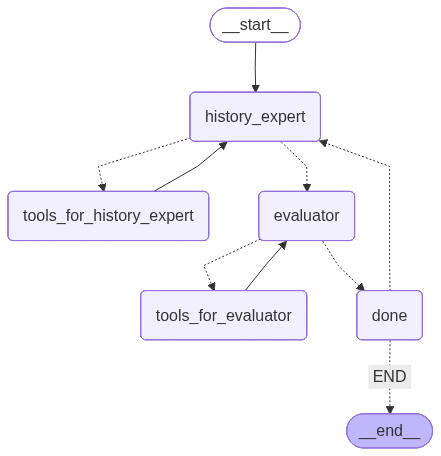

In [154]:
# Step 5: Compile the graph
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### 5. Test it Out
Use Gradio to create a front end that will allow us to test this out

In [155]:
memory_key = "jay_123"

config = {"configurable": {"thread_id": str(uuid.uuid4())}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gradio.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.
